<a href="https://colab.research.google.com/github/asxd-10/cis5300_project/blob/main/notebooks/Final_Extension_BILSTM_section_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import torch
import os
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
GPU: Tesla T4


In [4]:
!pip install -q transformers datasets jsonlines scikit-learn
!pip install pytorch-crf

In [5]:
!git clone https://github.com/asxd-10/cis5300_project.git

fatal: destination path 'cis5300_project' already exists and is not an empty directory.


In [6]:
import sys
sys.path.append('cis5300_project')

print('Contents of cis5300_project directory:')
!ls -F cis5300_project/

def load_pubmed_rct(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("###"):
                continue
            label, sentence = line.split("\t", 1)
            data.append((label, sentence))
    return data

def load_pubmed_rct_by_abstract(path):
    """
    Returns a list of abstracts, each abstract is a tuple (labels, sentences)
    """
    abstracts = []
    current_labels = []
    current_sents = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("###"):
                if current_sents:  # save previous abstract
                    abstracts.append((current_labels, current_sents))
                    current_labels = []
                    current_sents = []
                continue
            label, sentence = line.split("\t", 1)
            current_labels.append(label)
            current_sents.append(sentence)

    if current_sents:
        abstracts.append((current_labels, current_sents))

    return abstracts

print("Loading PubMed RCT data")


train_abstracts = load_pubmed_rct_by_abstract('cis5300_project/data/pubmed_rct/train.txt')
dev_abstracts   = load_pubmed_rct_by_abstract('cis5300_project/data/pubmed_rct/dev.txt')
test_abstracts  = load_pubmed_rct_by_abstract('cis5300_project/data/pubmed_rct/test.txt')

print(f"{len(train_abstracts)} training abstracts")
print(f"{len(dev_abstracts)} dev abstracts")
print(f"{len(test_abstracts)} test abstracts")

Contents of cis5300_project directory:
data/		     notebooks/  requirements.txt  src/
download_scifact.sh  README.md	 setup.sh
Loading PubMed RCT data
15000 training abstracts
2500 dev abstracts
2500 test abstracts


In [7]:
print(train_abstracts[0])

(['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS'], ['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .', 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .', 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .', 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .', 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .', 'Serum levels of interleukin @ ( IL

In [9]:
label2id = {
    "BACKGROUND": 0,
    "OBJECTIVE": 1,
    "METHODS": 2,
    "RESULTS": 3,
    "CONCLUSIONS": 4
}
id2label = {v: k for k, v in label2id.items()}

In [10]:
from collections import defaultdict, Counter

def preprocess(text):
    """
    Clean and normalize text.
    - Strip whitespace
    - Lowercase
    - Replace placeholders like '@' with <NUM>
    """
    text = text.strip().lower()
    text = text.replace("@", "<NUM>")
    return text

from collections import Counter

word_counter = Counter()
for labels, sents in train_abstracts:
    for sent in sents:
        sent = preprocess(sent)
        word_counter.update(sent.split())

word2idx = {"<PAD>": 0, "<UNK>": 1}
for i, word in enumerate(word_counter.keys(), start=2):
    word2idx[word] = i

idx2word = {idx: word for word, idx in word2idx.items()}

VOCAB_SIZE = len(word2idx)
print("Vocabulary size:", VOCAB_SIZE)


#Tokenization + Vocabulary

def tokenize_sentence(sentence):
    return sentence.split()

def build_vocab(sentences):
    """
    sentences: list of lists of sentences (abstracts)
    """
    for abstract in sentences:
        for sent in abstract:
            for word in tokenize_sentence(sent):
                _ = word2idx[word]

def encode_abstracts(abstracts):
    """
    abstracts: list of tuples (labels, sentences)
    Returns:
        sentence_tokens: list of list of tokenized sentences
        label_ids: list of list of label ids
    """
    sentence_tokens = []
    label_ids = []

    for labels, sents in abstracts:
        sent_list = [preprocess(s) for s in sents]
        sentence_tokens.append(sent_list)
        label_ids.append([label2id[l] for l in labels])

    return sentence_tokens, label_ids

Vocabulary size: 69734


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

def sentence_to_indices(sentence, word2idx, max_len=None):
    indices = [word2idx.get(w, word2idx["<UNK>"]) for w in sentence]
    if max_len:
        if len(indices) < max_len:
            indices += [word2idx["<PAD>"]] * (max_len - len(indices))
        else:
            indices = indices[:max_len]
    return indices

class PubMedSentenceDataset(Dataset):
    def __init__(self, abstracts, label2id, word2idx, max_sent_len=100):
        """
        abstracts: list of (labels, sentences)
        Each sentence is tokenized and converted to word indices
        """
        self.abstracts = abstracts
        self.label2id = label2id
        self.word2idx = word2idx
        self.max_sent_len = max_sent_len

    def __len__(self):
        return len(self.abstracts)

    def __getitem__(self, idx):
        labels, sents = self.abstracts[idx]
        sent_indices = []
        for sent in sents:
            tokens = preprocess(sent).split()
            idxs = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in tokens]
            if len(idxs) < self.max_sent_len:
                idxs += [self.word2idx["<PAD>"]] * (self.max_sent_len - len(idxs))
            else:
                idxs = idxs[:self.max_sent_len]
            sent_indices.append(torch.tensor(idxs, dtype=torch.long))

        label_ids = torch.tensor([self.label2id[l] for l in labels], dtype=torch.long)
        return sent_indices, label_ids


# 3. Collate function for variable-length sequences
def collate_fn(batch):
    """
    batch: list of (list of sentence tensors, label_ids)
    Pads abstracts to same number of sentences
    """
    max_sents = max(len(item[0]) for item in batch)

    padded_sents = []
    padded_labels = []
    mask = []

    for sents, labels in batch:
        # Pad sentences
        pad_count = max_sents - len(sents)
        padded_sents.append(torch.stack(sents + [torch.zeros_like(sents[0])]*pad_count))
        padded_labels.append(torch.cat([labels, torch.full((pad_count,), -1)]))  # -1 for padding labels
        mask.append(torch.tensor([1]*len(sents) + [0]*pad_count, dtype=torch.bool))

    padded_sents = torch.stack(padded_sents)  # (batch_size, seq_len, max_sent_len)
    padded_labels = torch.stack(padded_labels)  # (batch_size, seq_len)
    mask = torch.stack(mask)  # (batch_size, seq_len)

    return padded_sents, padded_labels, mask

BATCH_SIZE = 32

print("Dataset and DataLoader ready.")


Dataset and DataLoader ready.


In [37]:
import torch
import torch.nn as nn
from torchcrf import CRF

class SentenceBiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, pad_idx, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim // 2,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.hidden2tag = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, x, tags=None, mask=None):
        """
        x: (batch_size, seq_len, max_sent_len)
        tags: (batch_size, seq_len)
        mask: (batch_size, seq_len)
        """
        batch_size, seq_len, max_sent_len = x.shape
        embeds = self.embedding(x)           # (B, S, L, E)
        sent_embeds = embeds.mean(dim=2)     # average over tokens -> (B, S, E)
        sent_embeds = self.dropout(sent_embeds)

        lstm_out, _ = self.lstm(sent_embeds) # (B, S, H)
        lstm_out = self.dropout(lstm_out)

        emissions = self.hidden2tag(lstm_out)  # (B, S, num_labels)

        if tags is not None:
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            pred_tags = self.crf.decode(emissions, mask=mask)
            return pred_tags


VOCAB_SIZE = len(word2idx)
EMBED_DIM = 300
HIDDEN_DIM = 256
NUM_LABELS = len(label2id)
PAD_IDX = word2idx["<PAD>"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# print(model)


In [39]:
train_dataset = PubMedSentenceDataset(train_abstracts, label2id, word2idx, max_sent_len=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

dev_dataset = PubMedSentenceDataset(dev_abstracts, label2id, word2idx, max_sent_len=100)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [40]:
model = SentenceBiLSTM_CRF(
    VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LABELS, PAD_IDX, lstm_layers=2, dropout=0.35
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)

print(model)

SentenceBiLSTM_CRF(
  (embedding): Embedding(69734, 300, padding_idx=0)
  (dropout): Dropout(p=0.35, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=5, bias=True)
  (crf): CRF(num_tags=5)
)


In [41]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y, mask in loader:
            batch_x, batch_y, mask = batch_x.to(device), batch_y.to(device), mask.to(device)
            preds = model(batch_x, mask=mask)  # list of lists

            for p, y, m in zip(preds, batch_y, mask):
                valid_len = m.sum().item()
                all_preds.extend(p[:valid_len])
                all_labels.extend(y[:valid_len].tolist())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, macro_f1


In [42]:
EPOCHS = 15
best_f1 = 0.0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_x, batch_y, mask in train_loader:
        batch_x, batch_y, mask = batch_x.to(device), batch_y.to(device), mask.to(device)
        optimizer.zero_grad()

        loss = model(batch_x, tags=batch_y, mask=mask)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    acc, macro_f1 = evaluate(dev_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
    print(f"Dev Accuracy: {acc:.4f}, Dev Macro-F1: {macro_f1:.4f}")

    scheduler.step(macro_f1)

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), "best_bilstm_crf_model.pt")
        print(f"Model saved with Macro-F1: {best_f1:.4f}")

Epoch 1/15, Loss: 5.9654
Dev Accuracy: 0.8696, Dev Macro-F1: 0.8045
Model saved with Macro-F1: 0.8045
Epoch 2/15, Loss: 3.3389
Dev Accuracy: 0.8879, Dev Macro-F1: 0.8232
Model saved with Macro-F1: 0.8232
Epoch 3/15, Loss: 2.7642
Dev Accuracy: 0.8969, Dev Macro-F1: 0.8303
Model saved with Macro-F1: 0.8303
Epoch 4/15, Loss: 2.4162
Dev Accuracy: 0.9015, Dev Macro-F1: 0.8383
Model saved with Macro-F1: 0.8383
Epoch 5/15, Loss: 2.1643
Dev Accuracy: 0.9047, Dev Macro-F1: 0.8510
Model saved with Macro-F1: 0.8510
Epoch 6/15, Loss: 1.9559
Dev Accuracy: 0.9090, Dev Macro-F1: 0.8537
Model saved with Macro-F1: 0.8537
Epoch 7/15, Loss: 1.7764
Dev Accuracy: 0.9093, Dev Macro-F1: 0.8596
Model saved with Macro-F1: 0.8596
Epoch 8/15, Loss: 1.5974
Dev Accuracy: 0.9142, Dev Macro-F1: 0.8611
Model saved with Macro-F1: 0.8611
Epoch 9/15, Loss: 1.4459
Dev Accuracy: 0.9128, Dev Macro-F1: 0.8628
Model saved with Macro-F1: 0.8628
Epoch 10/15, Loss: 1.2978
Dev Accuracy: 0.9139, Dev Macro-F1: 0.8669
Model saved w

In [43]:
FINE_TUNE_EPOCHS = 10         # max epochs for fine-tuning
EARLY_STOP_PATIENCE = 3       # stop if no improvement for these many epochs
FINE_LR = 0.0005              # smaller LR for fine-tuning

optimizer = torch.optim.Adam(model.parameters(), lr=FINE_LR)

best_f1 = 0.0
patience_counter = 0

for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    total_loss = 0

    for batch_x, batch_y, mask in train_loader:
        batch_x, batch_y, mask = batch_x.to(device), batch_y.to(device), mask.to(device)
        optimizer.zero_grad()
        loss = model(batch_x, tags=batch_y, mask=mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    acc, macro_f1 = evaluate(dev_loader)
    print(f"Epoch {epoch+1}/{FINE_TUNE_EPOCHS}, Loss: {avg_loss:.4f}")
    print(f"Dev Accuracy: {acc:.4f}, Dev Macro-F1: {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), "best_bilstm_crf_finetune.pt")
        print(f"Model saved with Macro-F1: {best_f1:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"No improvement for {EARLY_STOP_PATIENCE} epochs. Early stopping...")
            break

Epoch 1/10, Loss: 0.7276
Dev Accuracy: 0.9161, Dev Macro-F1: 0.8705
Model saved with Macro-F1: 0.8705
Epoch 2/10, Loss: 0.6797
Dev Accuracy: 0.9147, Dev Macro-F1: 0.8668
Epoch 3/10, Loss: 0.6420
Dev Accuracy: 0.9169, Dev Macro-F1: 0.8704
Epoch 4/10, Loss: 0.6066
Dev Accuracy: 0.9155, Dev Macro-F1: 0.8691
No improvement for 3 epochs. Early stopping...


In [44]:

model.load_state_dict(torch.load("best_bilstm_crf_finetune.pt"))
model.eval()

test_dataset = PubMedSentenceDataset(test_abstracts, label2id, word2idx, max_sent_len=100)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

test_acc, test_macro_f1 = evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}, Test Macro-F1: {test_macro_f1:.4f}")

Test Accuracy: 0.9130, Test Macro-F1: 0.8667


In [45]:
from sklearn.metrics import classification_report

def get_all_predictions(loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y, mask in loader:
            batch_x, batch_y, mask = batch_x.to(device), batch_y.to(device), mask.to(device)
            preds = model(batch_x, mask=mask)

            for p, y, m in zip(preds, batch_y, mask):
                valid_len = m.sum().item()
                all_preds.extend(p[:valid_len])
                all_labels.extend(y[:valid_len].tolist())

    return all_labels, all_preds

y_true, y_pred = get_all_predictions(test_loader)

report = classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(NUM_LABELS)],
    digits=4
)

print("\n=== Detailed Classification Report for Test set===\n")
print(report)



=== Detailed Classification Report for Test set===

              precision    recall  f1-score   support

  BACKGROUND     0.7811    0.8031    0.7919      3621
   OBJECTIVE     0.7081    0.6622    0.6844      2333
     METHODS     0.9433    0.9683    0.9556      9897
     RESULTS     0.9554    0.9453    0.9503      9713
 CONCLUSIONS     0.9632    0.9398    0.9514      4571

    accuracy                         0.9130     30135
   macro avg     0.8702    0.8638    0.8667     30135
weighted avg     0.9125    0.9130    0.9126     30135



In [47]:
y_true, y_pred = get_all_predictions(dev_loader)

report = classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(NUM_LABELS)],
    digits=4
)

print("\n=== Detailed Classification Report for Dev Set===\n")
print(report)


=== Detailed Classification Report for Dev Set===

              precision    recall  f1-score   support

  BACKGROUND     0.7759    0.8049    0.7901      3449
   OBJECTIVE     0.7272    0.6831    0.7044      2376
     METHODS     0.9530    0.9667    0.9598      9964
     RESULTS     0.9522    0.9525    0.9524      9841
 CONCLUSIONS     0.9600    0.9323    0.9460      4582

    accuracy                         0.9161     30212
   macro avg     0.8736    0.8679    0.8705     30212
weighted avg     0.9158    0.9161    0.9158     30212



Error Analysis

In [48]:
model.eval()
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch_x, batch_y, mask in test_loader:
        batch_x, batch_y, mask = batch_x.to(device), batch_y.to(device), mask.to(device)
        preds = model(batch_x, mask=mask)

        for p, y, m, x in zip(preds, batch_y, mask, batch_x):
            valid_len = m.sum().item()
            sentence_words = [[idx2word[idx.item()] for idx in sent[:valid_len]] for sent in x[:valid_len]]
            all_texts.extend([' '.join(words) for words in sentence_words])
            all_labels.extend(y[:valid_len].tolist())
            all_preds.extend(p[:valid_len])

In [49]:
# 2. Identify misclassified examples
errors = [(text, true, pred) for text, true, pred in zip(all_texts, all_labels, all_preds) if true != pred]
print(f"Total sentences: {len(all_texts)}")
print(f"Total misclassified: {len(errors)} ({len(errors)/len(all_texts)*100:.2f}%)\n")

print("Sample misclassifications:")
for i, (text, true, pred) in enumerate(errors[:10]):
    print(f"{i+1}. True: {true}, Pred: {pred}, Text: {text}")

Total sentences: 30135
Total misclassified: 2621 (8.70%)

Sample misclassifications:
1. True: 3, Pred: 2, Text: a post hoc analysis was conducted with the use
2. True: 3, Pred: 2, Text: liver function tests ( <UNK> ) were measured at
3. True: 3, Pred: 4, Text: nor was evar superior regarding cost-utility . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
4. True: 0, Pred: 1, Text: evidence suggests that individuals with social anxiety demonstrate vigilance
5. True: 2, Pred: 1, Text: this study investigated whether oxytocin can affect attentional bias
6. True: 3, Pred: 4, Text: the biological mechanisms by which oxytocin may be exerting
7. True: 1, Pred: 0, Text: depressive disorders are one of the leading components of the global burden of disease
8. True: 1, Pred: 0, Text: numerous studies have demonstrated that pharmacotherapy combined with non-pharmacological measures offer the best treatment
9. True: 1, Pred: 0, Text: psycho-education as an intervention has been studied mostly in disorders such

In [51]:
# 3. Analyze misclassifications by class
misclassified_labels = [true for _, true, _ in errors]
class_error_counts = Counter(misclassified_labels)
print("\nErrors per true class:")
for label_id, count in class_error_counts.items():
    print(f"Label {label_id} ({list(label2id.keys())[list(label2id.values()).index(label_id)]}): {count}")



Errors per true class:
Label 3 (RESULTS): 531
Label 0 (BACKGROUND): 713
Label 2 (METHODS): 314
Label 1 (OBJECTIVE): 788
Label 4 (CONCLUSIONS): 275


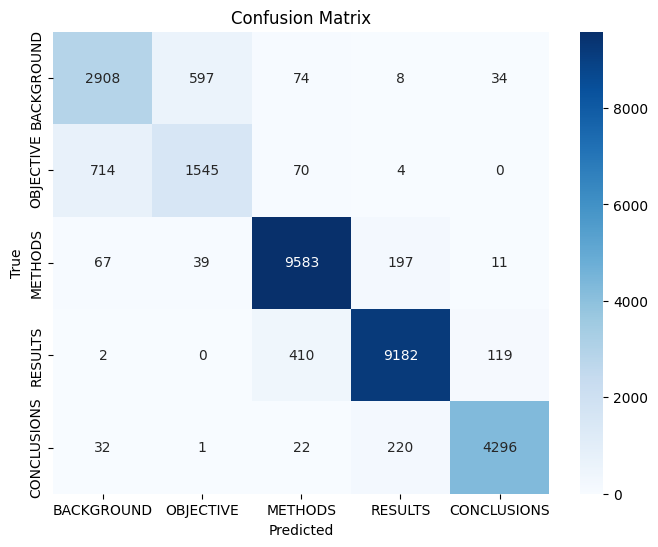

In [54]:
# 4. Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(all_labels, all_preds, labels=list(range(NUM_LABELS)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label2id.keys(), yticklabels=label2id.keys(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

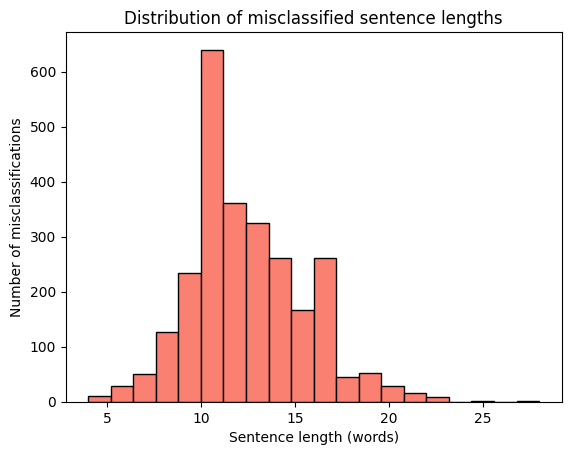

In [55]:
# 5. Analyze sentence lengths of errors
error_lengths = [len(text.split()) for text, _, _ in errors]
plt.hist(error_lengths, bins=20, color='salmon', edgecolor='black')
plt.xlabel("Sentence length (words)")
plt.ylabel("Number of misclassifications")
plt.title("Distribution of misclassified sentence lengths")
plt.show()